## Import libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels
from statsmodels.formula.api import ols
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

# GEOPANDAS

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Data Summary and Goal

The data provided is a collection of records of successful house sales and those homes' living attributes, such as:

1. Number of Floors
2. Amount of living space
3. Price
4. Number of assorted rooms (bathrooms, bedrooms)
5. Location
6. ETC.


The goal of this project is to create a relatively accurate prediction model for the prices that future houses sell for. We will explore how different factors affect the pricing the homes, given the data, and compile the most important features into a compatible regression model.

The final result will be a flexible prediciton model(s) that allow for easy prediction of future price sales given certain criteria!

## Data Inspection and Cleaning

In [2]:
# Import data
df = pd.read_csv('../my_project_workspace_repo/data/kc_house_data.csv')

# Display shape and .head()
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Check data types and missing values
df.info()
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Examine missing values

# df[df['yr_renovated'].isna()]
df['yr_renovated'].fillna(0, inplace=True)
# Replace all of the Null values with zeros so we can get a better idea of the amount of missing values in this column.
percent_not_renovated = df[df['yr_renovated'] == 0].value_counts().sum() / df['yr_renovated'].value_counts().sum()
# This is the percentage of houses that weren't renovated!



df['waterfront'].fillna(0., inplace=True)
# df['view'].unique()
# The waterfront column only has a 1 or a 0 to specify if the house has a waterfront. The NaN values here can be treated as no waterfront.

df.dropna(how = 'any', inplace=True)
# Drop all rows with missing 'view' data

In [5]:
# Dealing with the 'sqft_basement' column. 

# Checking to see if my guess that all of the elements in the series are str types is true
for x in df['sqft_basement']:
    not_str_sqft = 0
    if type(x) != str:
        not_str_sqft += 1
        

# All of the elements in this series are of type str
if not_str_sqft == 0:
    # Replacing original series
    converted_to_str = pd.to_numeric(df['sqft_basement'], errors='coerce')
    df['sqft_basement'] = converted_to_str
    # Confirm that the series has been converted successfully
    if df['sqft_basement'].dtype == np.float64:
        pass
    



In [6]:
# Now have to convert all of the dates in the 'date' column to something I can work with (a datetime object)
from datetime import datetime

for x in df['date']:
    not_str_date = 0
    if type(x) != str:
        not_str_date += 1
        
datetime_objects = []
if not_str_date == 0:
    for string in df['date']:
        string = pd.to_datetime(string)
        datetime_objects.append(string)
    df['date'] = datetime_objects

## Target and Features

In [7]:
target = ['price']
dense_factors = ['sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']
sparse_factors = ['bedrooms', 'bathrooms', 'floors','view', 'grade']
category_factors = ['yr_built', 'yr_renovated', 'waterfront', 'condition']
other_factors = ['date', 'zipcode']

custom_factors = ['age', 'relative distance from nearest attraction', 'season']

## Collinearity check

AxesSubplot(0.125,0.125;0.62x0.755)


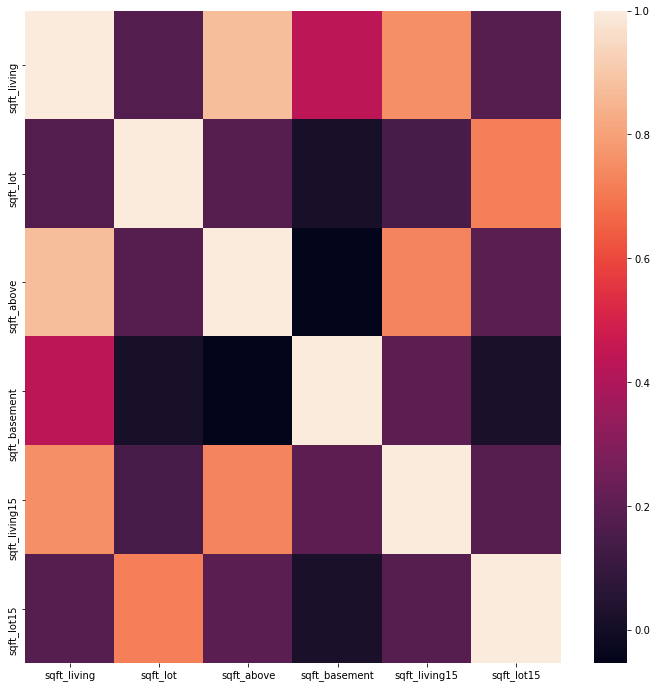

In [8]:
# Preliminary collinearity check
fig, ax = plt.subplots(figsize=(12,12))
print(sns.heatmap(df[dense_factors].corr(), ax=ax))

## Date and Seasons and Age

In [43]:
# Identify each sale by year
years = []
for date in df['date']:
    years.append(date.year)

df['sale_year'] = years
print(df['sale_year'].value_counts())

# Why were there almost 3 times as many sales in 2015 compared to 2014?

2014    14588
2015     6946
Name: sale_year, dtype: int64


In [10]:
# Age of house at sale?
df['age'] = df['sale_year'] - df['yr_built']
df['age'].value_counts().sort_index()
# A couple homes (12 to be exact) have an age of -1. This is odd and needs looking into


-1       12
 0      429
 1      284
 2      174
 3      165
       ... 
 111     50
 112     33
 113     28
 114     69
 115     26
Name: age, Length: 117, dtype: int64

In [41]:
# df[df['age'] == -1][['yr_built', 'sale_year']]
# All 12 of these houses were built the year after they were bought! Indicates potentially high demand. Am curious where these houses are located
# They are all very expensive homes
# All in the wealthy section of the county?

2    6493
3    6320
4    5042
1    3679
Name: seasons, dtype: int64


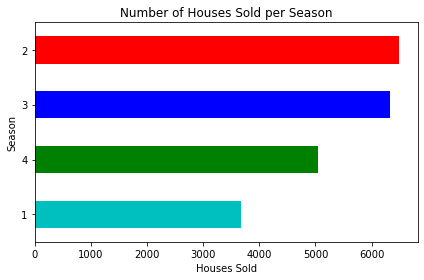

In [50]:
# Convert the dates to seasons. Now we know which season each house was sold in. 
month = []
for x in df['date']:
    month.append(x.month)
df['month'] = month
df['seasons'] = df['month']%12 // 3 + 1


# Visualize the amount of houses sold per season
print(df['seasons'].value_counts())
df['seasons'].value_counts().sort_values().plot(kind = 'barh', color=['c','g','b','r'])
plt.title('Number of Houses Sold per Season')
plt.xlabel('Houses Sold')
plt.ylabel('Season')
plt.tight_layout()

## Price Distribution

In [12]:
price_mean = df['price'].mean()
price_std = df['price'].std()
price_mean, price_std

(540057.663833937, 366059.58123129635)

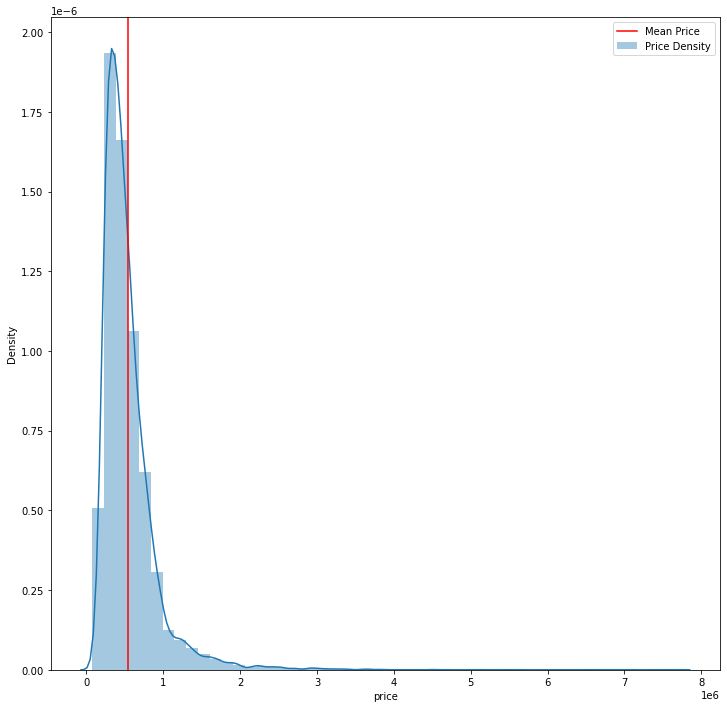

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.distplot(df['price'], label='Price Density')
plt.axvline(price_mean, color='red', label='Mean Price')
plt.legend()

## Floors

Text(0.5, 1.0, 'Avg Prices per Floor #')

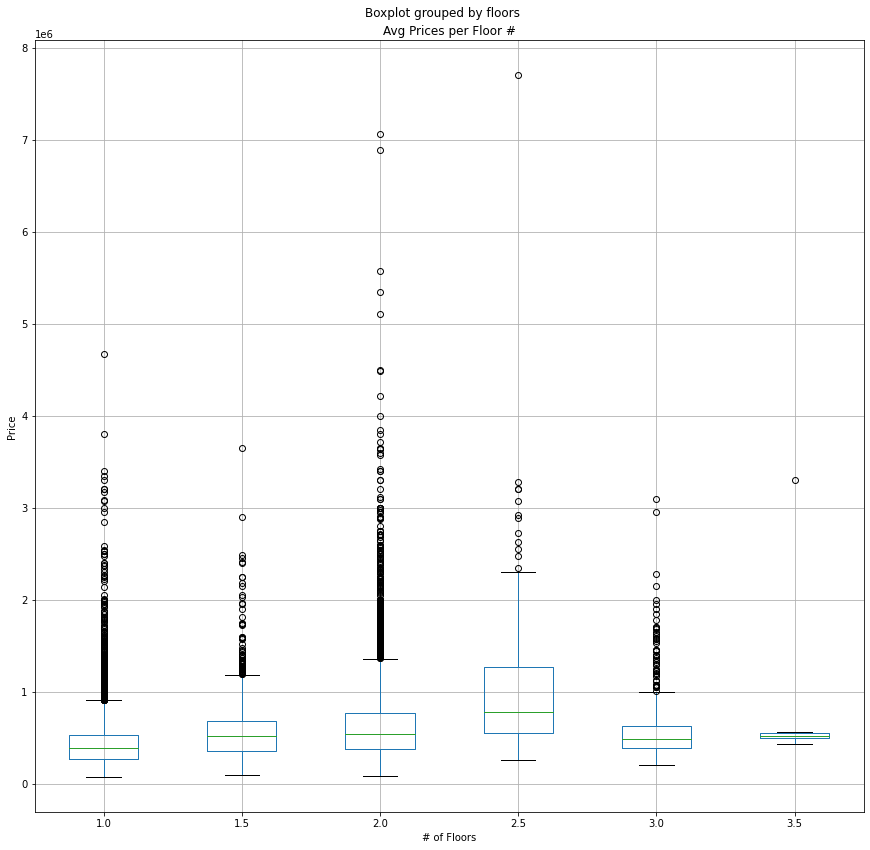

In [15]:
df['floors']
df.boxplot('price', by='floors', figsize=(12,12))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('# of Floors')
plt.title('Avg Prices per Floor #')

1.0    10643
2.0     8211
1.5     1903
3.0      611
2.5      159
3.5        7
Name: floors, dtype: int64


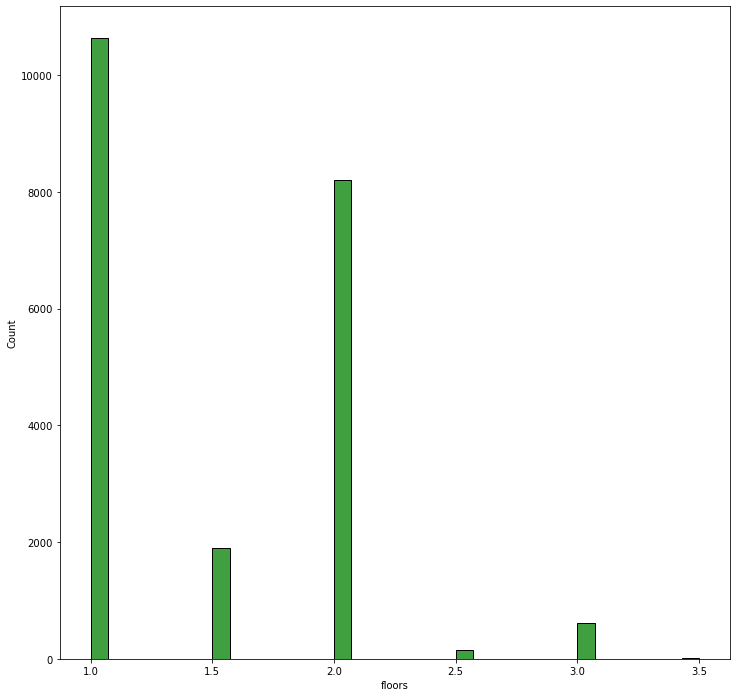

In [20]:
# For each number of floors, how many house sales were there? So how many 1 floor houses were sold? 2 floor? etc...
fig, axes = plt.subplots(figsize=(12,12))
sns.histplot(df['floors'], color = 'green')
print(df['floors'].value_counts())

## Sqft_living

price          1.000000
sqft_living    0.701587
Name: price, dtype: float64

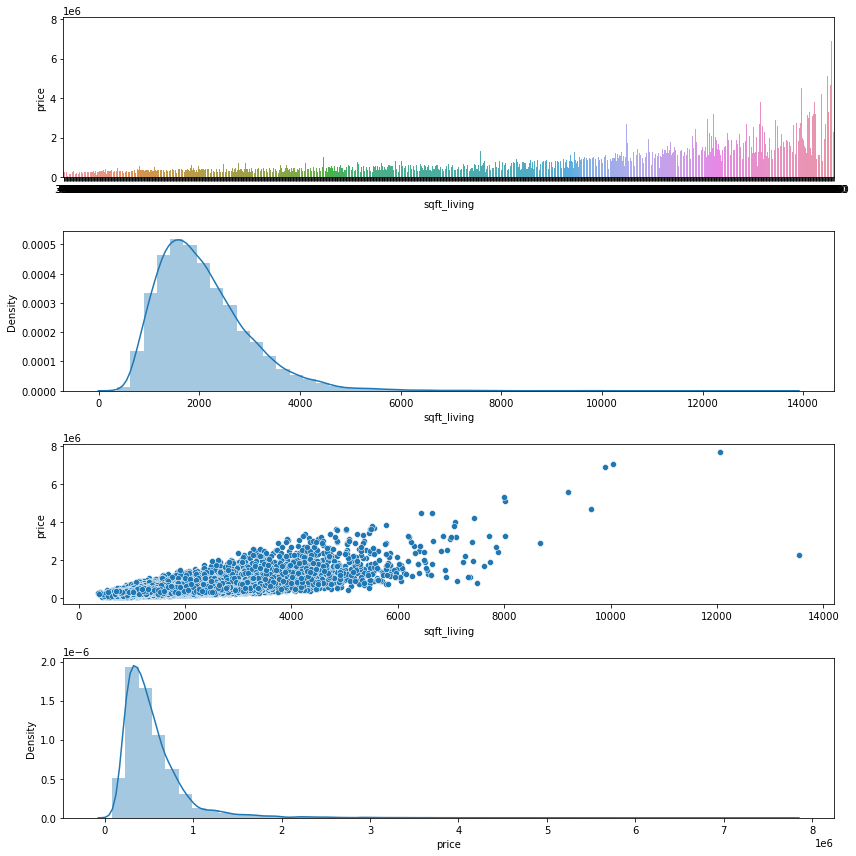

In [52]:
# Bar plot of sqft_living to price
fig, axes = plt.subplots(4,1, figsize=(12,12))

sns.barplot(x='sqft_living', y='price', data=df, ci=None, ax = axes[0])



sns.distplot(df['sqft_living'], ax=axes[1])



sns.distplot(df['price'], ax=axes[3])


sns.scatterplot(x='sqft_living', y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()
# The average of the living square feet is displayed with a red line on the pdf graph

# The results indicate a clear correlation between the living space size and the price. As living space size goes up, generally so does price.

# The strong correlation coefficient between the two variables helps validate this claim
df.corr()['price'][df.corr()['price'] >= .70]



## Location